# Broker Analysis

Import CSV with Pre-Processed Data

In [ ]:
import pandas as pd

# import preprocessed csv and print out cols
df = pd.read_csv('housing_data-3.csv')
df = df.drop(['description', 'Unnamed: 0'], axis=1)
df = df.rename(columns={'description.1': 'description'})
df = df.dropna()
df.columns

Make GeoDataframe for Mapping Houses on SF Map

In [ ]:
import geopandas as gpd

# create a geospacial dataframe to map houses using long/lat
gdf_df = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(
        x=df["longitude"],
        y=df["latitude"]
    ),
    crs="EPSG:4326"
)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 58.0 MB/s eta 0:00:00


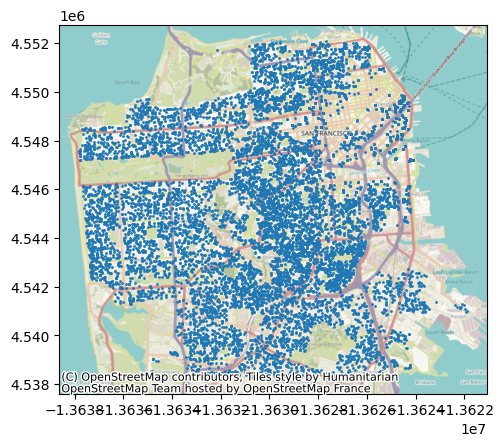

In [ ]:
!pip install contextily -q
import contextily as cx

# plot the dataframe on a map
ax = gdf_df.to_crs("EPSG:3857").plot(markersize=1)
cx.add_basemap(ax)

For Every Home: Find Most Similar/Nearby Homes, Group by Broker, and Get Standard Devation

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import pairwise_distances, cosine_similarity
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer

# calculate the geographic distances between each home and every other using pairwise, getting 300 closest for each
df[['latitude', 'longitude']] = np.radians(df[['latitude', 'longitude']])
geo_distances = pairwise_distances(df[['latitude', 'longitude']], metric="haversine") * 6371
idx_300 = np.argsort(geo_distances, axis=1)[:, 1:301]

# prep to get 50 most similar homes by selecting features, waiting square footage more heavily, and Tfidf vectorizing the description (cosine as distance metric)
features = ['beds', 'lotSize', 'baths', 'yearBuilt', 'sqft', 'population', 'density']
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[features])

weights = np.ones(len(features))
weights[features.index('sqft')] = 2
scaled_features *= weights

vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
tfidf_matrix = vectorizer.fit_transform(df['description'].fillna(""))
text_similarities = cosine_similarity(tfidf_matrix)

idx_50 = np.zeros((df.shape[0], 50), dtype=int)

# get 50 most similar homes out of 300 by gettting home feature distances and description distances
for i in range(df.shape[0]):
    neighbors = idx_300[i]

    feature_distances = pairwise_distances([scaled_features[i]], scaled_features[neighbors])[0]
    text_scores = text_similarities[i, neighbors]
    feature_sim = 1 / (1 + feature_distances)
    combined_sim = 0.85 * feature_sim + 0.15 * text_scores

    idx_50[i] = neighbors[np.argsort(combined_sim)[-50:][::-1]]

# for each home, add to a bigger dataframe the 50 most similar, nearby homes, getting standard deviation of average price by broker
df_expanded = df.iloc[idx_50.flatten()][['buyer_broker', 'url', 'beds', 'price', 'lotSize', 'baths', 'yearBuilt', 'sqft', 'days_on_market', 'population', 'density']].copy()
df_expanded['home_id'] = np.repeat(df.index, 50)

avg_price_per_broker = df_expanded.groupby(['home_id', 'buyer_broker'])['price'].mean().reset_index()
std_dev_prices = avg_price_per_broker.groupby('home_id')['price'].std().reset_index()
std_dev_prices.rename(columns={'price': 'buy_broker_var'}, inplace=True)

df = df.merge(std_dev_prices, left_index=True, right_on='home_id', how='left')
df['buy_broker_var'].fillna(0, inplace=True)
df['buy_broker_var'] = df['buy_broker_var'] / df['price']
df

<ipython-input-4-ace10d70f728>:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['buy_broker_var'].fillna(0, inplace=True)


,url,lastSoldDate,listingAddedDate,beds,price,lotSize,baths,yearBuilt,sqft,days_on_market,...,longitude,latitude,seller_agent,seller_broker,buyer_agent,buyer_broker,yearListed,monthListed,home_id,buy_broker_var
0,/CA/San-Francisco/3228-Santiago-St-94116/home/...,2021-04-23T07:00:00Z,2021-04-02T17:34:02.324Z,3.0,1452500,2495.0,1.0,1941.0,1000.0,21,...,-2.138065,0.658756,Ali Mafi,Redfin,Kent Chen,Compass,2021,4,1,0.130214
1,/CA/San-Francisco/2127-Balboa-St-94121/home/10...,2022-10-28T07:00:00Z,2022-10-02T05:56:58.367Z,2.0,1300000,2500.0,1.0,1934.0,984.0,26,...,-2.137711,0.659320,Alex Sobieski,Redfin,Dylan Hunter,Compass,2022,10,4,0.208221
2,/CA/San-Francisco/91-Stoneyford-Ave-94112/home...,2024-05-08T07:00:00Z,2024-04-15T19:34:54.328Z,3.0,1130000,2426.0,1.0,1942.0,1042.0,23,...,-2.136652,0.658504,Ali Mafi,Redfin,Nubia Tovar,EXP Realty of California,2024,4,6,0.173675
3,/CA/San-Francisco/2189-Market-St-94114/unit-7/...,2021-05-26T07:00:00Z,2021-05-19T17:55:49.660Z,2.0,1165000,8182.0,1.0,2002.0,770.0,7,...,-2.136818,0.659139,Joshua Altman,Redfin,Jeremy Davidson,Compass,2021,5,7,0.174297
4,/CA/San-Francisco/2250-24th-St-94107/unit-325/...,2023-03-17T07:00:00Z,2023-02-13T20:27:39.990Z,2.0,665000,80224.0,1.0,1989.0,836.0,32,...,-2.136322,0.658930,Joshua Altman,Redfin,Vantika Singh,"FlyHomes, Inc",2023,2,8,0.355561
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12002,/CA/San-Francisco/75-Santa-Marina-St-94110/hom...,2024-05-10T07:00:00Z,2024-03-14T19:30:54.373Z,4.0,1150000,1250.0,1.0,1907.0,1362.0,57,...,-2.136658,0.658690,Andres Restrepo,Compass,Michelle Pender,Engel & Voelkers San Francisco,2024,3,17071,0.232847
12003,/CA/San-Francisco/330-3rd-Ave-94118/home/52124720,2020-09-14T07:00:00Z,2020-06-29T18:39:36.792Z,5.0,3920000,3001.0,4.5,1900.0,3795.0,77,...,-2.137348,0.659430,Nina Hatvany,Compass,John Kirkpatrick,Compass,2020,6,17072,0.150468
12004,/CA/San-Francisco/1-Daniel-Burnham-Ct-94109/un...,2023-11-17T08:00:00Z,2023-09-21T19:34:43.197Z,1.0,710000,46157.0,1.0,1988.0,836.0,57,...,-2.136665,0.659504,Emily Tam,Berkshire Hathaway-Franciscan,Samantha Yu,Compass,2023,9,17073,0.167945
12005,/CA/San-Francisco/44-Everglade-Dr-94132/home/1...,2020-07-29T07:00:00Z,2020-06-10T18:38:31.878Z,4.0,1650000,3323.0,2.0,1950.0,1835.0,49,...,-2.137832,0.658569,Mark Campana,Anchor Realty,Sisley Wong,Grobecker Holland Int'l,2020,6,17075,0.151020


Example of the 50 Most Similar, Nearby Homes for home_id 1

In [ ]:
df_expanded[df_expanded['home_id'] == 1]

,buyer_broker,url,beds,price,lotSize,baths,yearBuilt,sqft,days_on_market,population,density,home_id
2059,Golden Gate Sotheby's Intl,/CA/San-Francisco/601-Ortega-St-94122/home/176...,3.0,3405000,7226.0,3.5,1952.0,3830.0,27,57369.0,6800.4,1742
9402,Coldwell Banker Realty,/CA/San-Francisco/1531-1533-10th-Ave-94122/hom...,4.0,1950000,2996.0,2.0,1925.0,3300.0,27,57369.0,6800.4,1742
9811,Coldwell Banker Realty,/CA/San-Francisco/1531-1533-10th-Ave-94122/hom...,4.0,1950000,2996.0,2.0,1925.0,3300.0,27,57369.0,6800.4,1742
7946,Compass,/CA/San-Francisco/100-Judah-St-94122/home/1812856,5.0,2225000,2374.0,2.0,1911.0,4124.0,24,57369.0,6800.4,1742
12103,Coldwell Banker Realty,/CA/San-Francisco/560-Ortega-St-94122/home/117...,4.0,3700000,4046.0,2.5,1974.0,3300.0,22,57369.0,6800.4,1742
12528,Compass,/CA/San-Francisco/1287-1291-3rd-Ave-94122/home...,5.0,2550000,2374.0,3.0,1907.0,4290.0,42,57369.0,6800.4,1742
12381,Compass,/CA/San-Francisco/1287-1291-3rd-Ave-94122/home...,5.0,2550000,2374.0,3.0,1907.0,4290.0,42,57369.0,6800.4,1742
6974,Rivet Real Estate,/CA/San-Francisco/1378-1380-16th-Ave-94122/hom...,4.0,2605000,3184.0,2.0,1927.0,3020.0,29,57369.0,6800.4,1742
12495,Compass,/CA/San-Francisco/1235-18th-Ave-94122/home/194...,4.0,1760000,2996.0,4.0,1946.0,4150.0,53,57369.0,6800.4,1742
1285,Compass,/CA/San-Francisco/1366-5th-Ave-94122/home/1724720,4.0,2740000,3001.0,4.0,1927.0,3886.0,40,57369.0,6800.4,1742


Run the Same Calculations for Seller's Broker

In [ ]:
# conduct same process as above code (without repeating unecessary steps) but for seller's broker, rather than buyer's broker
df_expanded = df.iloc[idx_50.flatten()][['seller_broker', 'url', 'beds', 'price', 'lotSize', 'baths', 'yearBuilt', 'sqft', 'days_on_market', 'population', 'density']].copy()
df_expanded['home_id'] = np.repeat(df.index, 50)

avg_price_per_broker = df_expanded.groupby(['home_id', 'seller_broker'])['price'].mean().reset_index()

std_dev_prices = avg_price_per_broker.groupby('home_id')['price'].std().reset_index()
std_dev_prices.rename(columns={'price': 'sell_broker_var'}, inplace=True)

df = df.merge(std_dev_prices, left_index=True, right_on='home_id', how='left')

df['sell_broker_var'].fillna(0, inplace=True)

df['sell_broker_var'] = df['sell_broker_var'] / df['price']
df

<ipython-input-5-98e3ab55242c>:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['sell_broker_var'].fillna(0, inplace=True)


,home_id,url,lastSoldDate,listingAddedDate,beds,price,lotSize,baths,yearBuilt,sqft,...,seller_agent,seller_broker,buyer_agent,buyer_broker,yearListed,monthListed,home_id_x,buy_broker_var,home_id_y,sell_broker_var
0,0,/CA/San-Francisco/3228-Santiago-St-94116/home/...,2021-04-23T07:00:00Z,2021-04-02T17:34:02.324Z,3.0,1452500,2495.0,1.0,1941.0,1000.0,...,Ali Mafi,Redfin,Kent Chen,Compass,2021,4,1,0.130214,0,0.115503
1,1,/CA/San-Francisco/2127-Balboa-St-94121/home/10...,2022-10-28T07:00:00Z,2022-10-02T05:56:58.367Z,2.0,1300000,2500.0,1.0,1934.0,984.0,...,Alex Sobieski,Redfin,Dylan Hunter,Compass,2022,10,4,0.208221,1,0.202271
2,2,/CA/San-Francisco/91-Stoneyford-Ave-94112/home...,2024-05-08T07:00:00Z,2024-04-15T19:34:54.328Z,3.0,1130000,2426.0,1.0,1942.0,1042.0,...,Ali Mafi,Redfin,Nubia Tovar,EXP Realty of California,2024,4,6,0.173675,2,0.187282
3,3,/CA/San-Francisco/2189-Market-St-94114/unit-7/...,2021-05-26T07:00:00Z,2021-05-19T17:55:49.660Z,2.0,1165000,8182.0,1.0,2002.0,770.0,...,Joshua Altman,Redfin,Jeremy Davidson,Compass,2021,5,7,0.174297,3,0.174048
4,4,/CA/San-Francisco/2250-24th-St-94107/unit-325/...,2023-03-17T07:00:00Z,2023-02-13T20:27:39.990Z,2.0,665000,80224.0,1.0,1989.0,836.0,...,Joshua Altman,Redfin,Vantika Singh,"FlyHomes, Inc",2023,2,8,0.355561,4,0.477931
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12002,12002,/CA/San-Francisco/75-Santa-Marina-St-94110/hom...,2024-05-10T07:00:00Z,2024-03-14T19:30:54.373Z,4.0,1150000,1250.0,1.0,1907.0,1362.0,...,Andres Restrepo,Compass,Michelle Pender,Engel & Voelkers San Francisco,2024,3,17071,0.232847,12002,0.273577
12003,12003,/CA/San-Francisco/330-3rd-Ave-94118/home/52124720,2020-09-14T07:00:00Z,2020-06-29T18:39:36.792Z,5.0,3920000,3001.0,4.5,1900.0,3795.0,...,Nina Hatvany,Compass,John Kirkpatrick,Compass,2020,6,17072,0.150468,12003,0.260688
12004,12004,/CA/San-Francisco/1-Daniel-Burnham-Ct-94109/un...,2023-11-17T08:00:00Z,2023-09-21T19:34:43.197Z,1.0,710000,46157.0,1.0,1988.0,836.0,...,Emily Tam,Berkshire Hathaway-Franciscan,Samantha Yu,Compass,2023,9,17073,0.167945,12004,0.176149
12005,12005,/CA/San-Francisco/44-Everglade-Dr-94132/home/1...,2020-07-29T07:00:00Z,2020-06-10T18:38:31.878Z,4.0,1650000,3323.0,2.0,1950.0,1835.0,...,Mark Campana,Anchor Realty,Sisley Wong,Grobecker Holland Int'l,2020,6,17075,0.151020,12005,0.118950


Plot Distributions of Standard Deviations

In [ ]:
import plotly.express as px

# graph distribution of standard deviations of average price by buyer's broker
fig = px.histogram(df['buy_broker_var'],
                   nbins=50,
                   title="Distribution of Standard Deviations of Average Price by Broker - Buy Side",
                   labels={"value": "Standard Deviation of Average Price by Broker", "count": "Frequency"},
                   opacity=0.7,
                   color_discrete_sequence=["blue"])

fig.update_layout(bargap=0.1,
                  xaxis_title="Standard Deviation of Average Price by Broker (% of home price)",
                  yaxis_title="Frequency",
                  template="plotly_white",
                  xaxis=dict(range=[0, 0.8]),
                  width=800,
                  height=500,
                  title=dict(x=0.5, y=0.95, font=dict(size=20)),
                  showlegend=False

)
fig.show()


In [ ]:
import plotly.express as px

# graph the distribution of standard deviations of the average price by seller's broker
fig = px.histogram(df['sell_broker_var'],
                   nbins=50,
                   title="Distribution of Standard Deviations of Average Price by Broker - Sell Side",
                   labels={"value": "Standard Deviation of Average Price by Broker", "count": "Frequency"},
                   opacity=0.7,
                   color_discrete_sequence=["green"])

fig.update_layout(bargap=0.1,
                  xaxis_title="Standard Deviation of Average Price by Broker (% of home price)",
                  yaxis_title="Frequency",
                  template="plotly_white",
                  xaxis=dict(range=[0, 0.8]),
                  width=800,
                  height=500,
                  title=dict(x=0.5, y=0.95, font=dict(size=20)),
                  showlegend=False

)
fig.show()

In [ ]:
from google.colab import files

# download data with standard deviations as a csv file
df.to_csv('housing_data-4.csv')
files.download('housing_data-4.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>